In [1]:
import pickle

def load_and_preview_features(file_path, dataset_name, print_limit=5):
    """
    加载并预览特征数据，只打印正负中性标签的前若干条。
    返回所有数据（未截断）。
    """
    with open(file_path, 'rb') as file:
        features = pickle.load(file)

    print(f"\n--- {dataset_name.upper()} DATASET ---")

    count = 0
    for i, item in enumerate(features):
        label = item.get('label', 'N/A')
        if label not in ['Positive', 'Negative', 'Neutral']:
            continue

        if count < print_limit:
            video_id = item.get('video_id', 'N/A')
            clip_id = item.get('clip_id', 'N/A')
            label_1 = item.get('label_1', 'N/A')
            mode = item.get('mode', 'N/A')
            text = item.get('text', 'N/A')
            text_feature_shape = item['text_feature'].shape if 'text_feature' in item else 'N/A'
            audio_feature_shape = item['audio_feature'].shape if 'audio_feature' in item else 'N/A'
            #vision_feature_shape = item['vision_features'].shape if 'vision_features' in item else 'N/A'
            #vision_feature_shape1 = item['vision_feature_resnet'].shape if 'vision_feature_resnet' in item else 'N/A'

            print(f"Item {i}:")
            print(f"  video_id: {video_id}")
            print(f"  clip_id: {clip_id}")
            print(f"  label_1: {label_1}")
            print(f"  label: {label}")
            print(f"  mode: {mode}")
            print(f"  text: {text}")
            print(f"  text_feature_shape: {text_feature_shape}")
            print(f"  audio_feature_shape: {audio_feature_shape}")
            #print(f"  vision_feature_shape (DenseNet): {vision_feature_shape}")
            #print(f"  vision_feature_shape (ResNet): {vision_feature_shape1}")
            print("-" * 50)
            count += 1

    print(f"共加载样本数: {len(features)}（其中三类标签样本展示前 {print_limit} 条）")
    return features

In [2]:
train_features = load_and_preview_features('/root/autodl-tmp/train_features.pkl', 'train')
valid_features = load_and_preview_features('/root/autodl-tmp/valid_features.pkl', 'valid')
test_features = load_and_preview_features('/root/autodl-tmp/test_features.pkl', 'test')


--- TRAIN DATASET ---
Item 0:
  video_id: -3g5yACwYnA
  clip_id: 10
  label_1: 1.0
  label: Positive
  mode: train
  text: N/A
  text_feature_shape: (1, 50, 768)
  audio_feature_shape: torch.Size([1, 1284, 1024])
--------------------------------------------------
Item 1:
  video_id: -3g5yACwYnA
  clip_id: 13
  label_1: 0.6666666865348816
  label: Positive
  mode: train
  text: N/A
  text_feature_shape: (1, 19, 768)
  audio_feature_shape: torch.Size([1, 438, 1024])
--------------------------------------------------
Item 2:
  video_id: -3g5yACwYnA
  clip_id: 3
  label_1: 0.0
  label: Neutral
  mode: train
  text: N/A
  text_feature_shape: (1, 40, 768)
  audio_feature_shape: torch.Size([1, 963, 1024])
--------------------------------------------------
Item 3:
  video_id: -3g5yACwYnA
  clip_id: 2
  label_1: 0.0
  label: Neutral
  mode: train
  text: N/A
  text_feature_shape: (1, 19, 768)
  audio_feature_shape: torch.Size([1, 711, 1024])
--------------------------------------------------
I

In [3]:
import numpy as np
import torch
from sklearn.preprocessing import LabelEncoder
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

# 假设 features 已经加载并包含在内
train_data = [item for item in train_features if item['mode'] == 'train']
valid_data = [item for item in valid_features if item['mode'] == 'valid']
test_data = [item for item in test_features if item['mode'] == 'test']

In [4]:
del train_features, valid_features,test_features

In [5]:
# 定义离散化函数
def discretize_label(score):
    if -3 <= score < -2.5:
        return -3
    elif -2.5 <= score < -1.5:
        return -2
    elif -1.5 <= score < -0.5:
        return -1
    elif -0.5 <= score < 0.5:
        return 0
    elif 0.5 <= score < 1.5:
        return 1
    elif 1.5 <= score < 2.5:
        return 2
    elif 2.5 <= score <= 3:
        return 3
    else:
        return None

# 将 label_1 离散化并保存为标签
train_y = np.array([discretize_label(item['label_1']) for item in train_data])
valid_y = np.array([discretize_label(item['label_1']) for item in valid_data])
test_y = np.array([discretize_label(item['label_1']) for item in test_data])



# 打印示例以验证离散化后的标签
print("Sample converted labels (train):", train_y[:500])
print("Sample converted labels (valid):", valid_y[:500])
print("Sample converted labels (test):", test_y[:500])

Sample converted labels (train): [ 1  1  0  0  1  1  0  1  0 -1  0  0  0 -1 -2  1  0  0 -2  0  0  0  0  2
  0  2  2  2  1  3  1  2  3  0  2  1  2 -1  0  1  2  2  2  2  2  0  0 -1
  0  0  0  0  1  0  0 -1 -2  0  2  1  1  1  2  2  1  1  1  0  2  0  0  0
  1  1  0  1  1  0  0  1  1  0  0  0  2  2  1  1  0  1  0  1  1  0 -1  0
 -1  1  0 -1  0  0  0  0  0  1  0  0  0  0  0  0  0  0  1 -1 -1  0  0  0
  0  0  0  0  0  1  1  1  1  1  0  1  0  0 -1  0  1  0  0  1  0  0  1  0
  0  1  0  0  1  0  0  0  0  0  0  0  1  1  1  0 -1  0  0  1  0  0  0  1
  1  1  1  0  0  1  1  2 -1  0 -1  0  0  0  2  1  1  0  1  0  0  0  0  1
  0  0  0  0  0  0  0  1  0  0  0 -1  0  1  0  0  0  0  0  0  0  0  0  1
  1  1  1  0  0  0  0  2  0  0  0  0  2  0  0  0  0  0  0  1  2  1  1  1
  0  0  0  0 -1  0  0  2  0  2  0  2  2  2  0  1  0  0 -1 -2  0  0  1  1
  0  0  0  0  1  0 -1  0 -1  0 -1  0  0  0  2  0  0  1  0  1  0  0  0 -1
  2  1  1  2 -1  1  0 -2 -1  0  0  0  0  0  0  1  1  2  2  0  0  0  0  0
  1  2  1  1  2  0

In [6]:
train_X_text = [item['text_feature'] for item in train_data]
valid_X_text = [item['text_feature'] for item in valid_data]
test_X_text = [item['text_feature'] for item in test_data]

train_X_audio = [item['audio_feature'] for item in train_data]
valid_X_audio = [item['audio_feature'] for item in valid_data]
test_X_audio = [item['audio_feature'] for item in test_data]

train_X_vision = [item['vision_feature_resnet'] for item in train_data]
valid_X_vision = [item['vision_feature_resnet'] for item in valid_data]
test_X_vision = [item['vision_feature_resnet'] for item in test_data]

In [7]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
# 初始化标签编码器
label_encoder = LabelEncoder()

# 对训练标签进行拟合并转换
train_Y = label_encoder.fit_transform(train_y)

# 使用相同的编码器来转换验证标签
valid_Y = label_encoder.transform(valid_y)

test_Y = label_encoder.transform(test_y)

In [8]:
import torch

# 将所有特征数据放入一个字典中
text_features = {
    'train_audio': train_X_audio,
    'valid_audio': valid_X_audio,
    'test_audio': test_X_audio
}

# 遍历字典，转换为tensor并去掉维度，然后打印形状
for key, features in text_features.items():
    for i, feature in enumerate(features):
        tensor_feature = torch.tensor(feature)  # 将特征转换为tensor
        tensor_feature = tensor_feature.squeeze(0)  # 去掉大小为1的维度（假设是第一个维度）
        text_features[key][i] = tensor_feature  # 更新字典中的值
        print(f"Feature in {key} at index {i} has shape: {tensor_feature.shape}")

Feature in train_audio at index 0 has shape: torch.Size([1284, 1024])
Feature in train_audio at index 1 has shape: torch.Size([438, 1024])
Feature in train_audio at index 2 has shape: torch.Size([963, 1024])
Feature in train_audio at index 3 has shape: torch.Size([711, 1024])
Feature in train_audio at index 4 has shape: torch.Size([821, 1024])
Feature in train_audio at index 5 has shape: torch.Size([811, 1024])
Feature in train_audio at index 6 has shape: torch.Size([464, 1024])
Feature in train_audio at index 7 has shape: torch.Size([591, 1024])
Feature in train_audio at index 8 has shape: torch.Size([546, 1024])
Feature in train_audio at index 9 has shape: torch.Size([573, 1024])
Feature in train_audio at index 10 has shape: torch.Size([121, 1024])
Feature in train_audio at index 11 has shape: torch.Size([366, 1024])
Feature in train_audio at index 12 has shape: torch.Size([407, 1024])
Feature in train_audio at index 13 has shape: torch.Size([573, 1024])
Feature in train_audio at ind

/tmp/ipykernel_4417/2523887850.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_feature = torch.tensor(feature)  # 将特征转换为tensor


Feature in train_audio at index 1680 has shape: torch.Size([116, 1024])
Feature in train_audio at index 1681 has shape: torch.Size([616, 1024])
Feature in train_audio at index 1682 has shape: torch.Size([389, 1024])
Feature in train_audio at index 1683 has shape: torch.Size([236, 1024])
Feature in train_audio at index 1684 has shape: torch.Size([941, 1024])
Feature in train_audio at index 1685 has shape: torch.Size([516, 1024])
Feature in train_audio at index 1686 has shape: torch.Size([666, 1024])
Feature in train_audio at index 1687 has shape: torch.Size([603, 1024])
Feature in train_audio at index 1688 has shape: torch.Size([351, 1024])
Feature in train_audio at index 1689 has shape: torch.Size([541, 1024])
Feature in train_audio at index 1690 has shape: torch.Size([753, 1024])
Feature in train_audio at index 1691 has shape: torch.Size([403, 1024])
Feature in train_audio at index 1692 has shape: torch.Size([188, 1024])
Feature in train_audio at index 1693 has shape: torch.Size([146,

In [9]:
import torch

# 将所有特征数据放入一个字典中
text_features = {
    'train_text': train_X_text,
    'valid_text': valid_X_text,
    'test_text': test_X_text
}

# 遍历字典，转换为tensor并去掉维度，然后打印形状
for key, features in text_features.items():
    for i, feature in enumerate(features):
        tensor_feature = torch.tensor(feature)  # 将特征转换为tensor
        tensor_feature = tensor_feature.squeeze(0)  # 去掉大小为1的维度（假设是第一个维度）
        text_features[key][i] = tensor_feature  # 更新字典中的值
        print(f"Feature in {key} at index {i} has shape: {tensor_feature.shape}")

Feature in train_text at index 0 has shape: torch.Size([50, 768])
Feature in train_text at index 1 has shape: torch.Size([19, 768])
Feature in train_text at index 2 has shape: torch.Size([40, 768])
Feature in train_text at index 3 has shape: torch.Size([19, 768])
Feature in train_text at index 4 has shape: torch.Size([41, 768])
Feature in train_text at index 5 has shape: torch.Size([30, 768])
Feature in train_text at index 6 has shape: torch.Size([43, 768])
Feature in train_text at index 7 has shape: torch.Size([22, 768])
Feature in train_text at index 8 has shape: torch.Size([22, 768])
Feature in train_text at index 9 has shape: torch.Size([32, 768])
Feature in train_text at index 10 has shape: torch.Size([7, 768])
Feature in train_text at index 11 has shape: torch.Size([20, 768])
Feature in train_text at index 12 has shape: torch.Size([14, 768])
Feature in train_text at index 13 has shape: torch.Size([12, 768])
Feature in train_text at index 14 has shape: torch.Size([22, 768])
Featur

In [10]:
from torch.utils.data import Dataset, DataLoader
import torch
from torch.nn.utils.rnn import pad_sequence

class ThreeModal_Dataset(Dataset):
    def __init__(self, text_features, audio_features, labels):
        self.text_features = text_features
        self.audio_features = audio_features
        #self.vision_features = vision_features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        text_features = self.text_features[idx]
        audio_features = self.audio_features[idx]
        #vision_features = self.vision_features[idx]
        labels = self.labels[idx]
        return text_features, audio_features, labels
    

def collate_fn(batch):
    # 从批次中分离音频特征、文本特征和标签
    text_features, audio_features, labels = zip(*batch)
    
    # 将音频特征和文本特征按照批次中最长的序列进行填充
    text_features_padded = pad_sequence(text_features, batch_first=True)    
    audio_features_padded = pad_sequence(audio_features, batch_first=True)
    #vision_features_padded = pad_sequence(vision_features, batch_first=True)    
    
    
    # 转换标签为张量
    labels = torch.tensor(labels)

    return text_features_padded, audio_features_padded, labels

In [11]:
train_Y_tensor = torch.tensor(train_Y)
valid_Y_tensor = torch.tensor(valid_Y)
test_Y_tensor = torch.tensor(test_Y)

# 创建Dataset实例
train_dataset = ThreeModal_Dataset(train_X_text, train_X_audio, train_Y_tensor)
valid_dataset = ThreeModal_Dataset(valid_X_text, valid_X_audio, valid_Y_tensor)
test_dataset = ThreeModal_Dataset(test_X_text, test_X_audio, test_Y_tensor)

# 创建DataLoader，使用自定义的collate_fn
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False, num_workers=2, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2, collate_fn=collate_fn)

In [12]:
del train_X_text, train_X_audio, train_X_vision, valid_X_text, valid_X_audio, valid_X_vision, valid_Y_tensor, test_X_text, test_X_audio, test_X_vision, test_Y_tensor

In [15]:
# =========================
# Supervised Contrastive (SupCon) Teacher: Text↔Audio Cross-Attention
# 正样本 = 同源跨模态 + 同标签样本（同/异模态）
# Subcon 是来自文章 Supervised Contrastive Learning
# =========================
import os, math, random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

# -------- Repro（SEED SETTING） --------
SEED = 3
def set_seed(seed: int) -> None:
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True; torch.backends.cudnn.benchmark = False

set_seed(SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
USE_AMP = True  # AMP 是 半精度 (float16/bfloat16) + 单精度 (float32) 混合训练，为了节约显存
#改成Flase有可能面临显存不足问题

# -------- Utility: Class-Balanced weights (Effective Number) --------
def compute_class_weights_from_loader(loader, num_classes=7, beta=0.999, device=None, label_index=2):
    """计算 Class-Balanced 权重；若不想用，传 None 给 CrossEntropyLoss 的 weight 即可。
    β 是控制“样本数增长时权重衰减的速度”。"""
    counts = np.zeros(num_classes, dtype=np.int64)
    for batch in loader:
        labels = batch[label_index] if len(batch) > label_index else batch[-1]
        counts += np.bincount(labels.detach().cpu().numpy(), minlength=num_classes)
    counts = np.maximum(counts, 1)#这行代码为了保证类别计数至少为 1，不会出现 0。
    effective_num = 1.0 - np.power(beta, counts)
    weights = (1.0 - beta) / effective_num
    weights = weights / weights.mean()
    w = torch.tensor(weights, dtype=torch.float32)
    return w.to(device) if device is not None else w

# -------- Attention Pooling (AMP-safe) --------
class _AttnPool(nn.Module):
    def __init__(self, d, drop=0.0):
        super().__init__()
        self.lin1 = nn.Linear(d, d)
        self.lin2 = nn.Linear(d, 1)
        self.drop = nn.Dropout(drop)
    def forward(self, x, lengths):  # x:[B,T,D], lengths:[B]
        h = torch.tanh(self.lin1(x))            # [B,T,D]
        w = self.lin2(h).squeeze(-1)            # [B,T]
        B, T, _ = x.size()
        mask = torch.arange(T, device=x.device)[None, :] >= lengths[:, None]  # True=pad

        # AI说：AMP 下用 FP32 + -inf 更稳——但我还没有很明白
        #-inf 是完全合法的浮点数，可以安全地喂给 softmax
        w32 = w.float()
        w32 = w32.masked_fill(mask, float('-inf'))
        a = torch.softmax(w32, dim=-1).to(x.dtype)  # [B,T] -> cast 回原 dtype

        # AI建议：若某样本长度为 0，兜底
        if (lengths == 0).any():
            zero_rows = (lengths == 0).nonzero(as_tuple=True)[0]
            a[zero_rows] = 0.0
            if T > 0:
                a[zero_rows, 0] = 1.0

        pooled = torch.bmm(a.unsqueeze(1), x).squeeze(1)  # [B,D]
        return self.drop(pooled), a

# -------- Positional Encoding --------
#和大多数的transformer一样
def sinusoidal_posenc(T: int, D: int, device):
    pe = torch.zeros(T, D, device=device)
    position = torch.arange(0, T, device=device, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, D, 2, device=device, dtype=torch.float) * (-math.log(10000.0) / D))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe  # [T,D]

# -------- FFN（前馈网络）--------
class _FFN(nn.Module):
    def __init__(self, d, drop=0.1, mult=4):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d, d*mult), nn.GELU(), nn.Dropout(drop),
            nn.Linear(d*mult, d), nn.Dropout(drop),
        )
    def forward(self, x): return self.net(x)

# -------- Model with SupCon --------
class TextAudioCrossAttentionClassifier(nn.Module):
    def __init__(self, text_dim, audio_dim, hidden_dim, num_heads,
                 dropout_rate=0.1, num_classes=7, proj_dim=128, modality_dropout_p=0.15,
                 temperature=0.07, same_utter_weight=2.0):
        super().__init__()
        self.dropout = nn.Dropout(dropout_rate)
        self.text_to_hidden  = nn.Linear(text_dim,  hidden_dim)
        self.audio_to_hidden = nn.Linear(audio_dim, hidden_dim)

        self.cross_text_q_audio_kv = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=num_heads, dropout=dropout_rate)
        self.cross_audio_q_text_kv = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=num_heads, dropout=dropout_rate)

        self.ln_ta_1 = nn.LayerNorm(hidden_dim); self.ffn_ta = _FFN(hidden_dim, drop=dropout_rate); self.ln_ta_2 = nn.LayerNorm(hidden_dim)
        self.ln_at_1 = nn.LayerNorm(hidden_dim); self.ffn_at = _FFN(hidden_dim, drop=dropout_rate); self.ln_at_2 = nn.LayerNorm(hidden_dim)

        self.text_pool  = _AttnPool(hidden_dim, drop=dropout_rate)
        self.audio_pool = _AttnPool(hidden_dim, drop=dropout_rate)

        self.gate = nn.Sequential(nn.Linear(hidden_dim*2, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, 1), nn.Sigmoid())
        self.classifier = nn.Sequential(nn.Linear(hidden_dim * 2, hidden_dim), nn.ReLU(), nn.Dropout(dropout_rate), nn.Linear(hidden_dim, num_classes))

        self.proj_t = nn.Sequential(nn.Linear(hidden_dim, hidden_dim), nn.GELU(), nn.Linear(hidden_dim, proj_dim))
        self.proj_a = nn.Sequential(nn.Linear(hidden_dim, hidden_dim), nn.GELU(), nn.Linear(hidden_dim, proj_dim))
        self.modality_dropout_p = modality_dropout_p
        self.temperature = temperature
        self.same_utter_weight = same_utter_weight

    @staticmethod #静态方法，避免受实例状态影响
    def _infer_pad_mask(x):  # x:[B,T,D]
        return (x.abs().sum(dim=-1) == 0)

    def _supcon(self, z_t: torch.Tensor, z_a: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
        """监督式对比学习（SupCon）+ 同源跨模态加权。"""
        B = z_t.size(0); T = self.temperature
        Z = torch.cat([z_t, z_a], dim=0)          # [2B, D]
        Z = F.normalize(Z, dim=-1)
        y = labels.view(-1)
        y2 = torch.cat([y, y], dim=0)             # [2B]

        mask_pos = (y2.unsqueeze(0) == y2.unsqueeze(1)).float()  # 同标签
        eye = torch.eye(2*B, device=Z.device)
        mask_pos = mask_pos * (1.0 - eye)         # 去掉自身

        # 同源跨模态加权 (t_i ↔ a_i)
        W = torch.ones_like(mask_pos)
        idx = torch.arange(B, device=Z.device)
        W[idx, idx + B] = self.same_utter_weight
        W[idx + B, idx] = self.same_utter_weight

        # 相似度 + log-softmax（FP32，稳定）
        logits = torch.matmul(Z.float(), Z.float().t()) / T
        logits = logits - 1e9 * eye
        log_prob = logits - torch.logsumexp(logits, dim=1, keepdim=True)

        weighted_logp = W * mask_pos * log_prob
        pos_weight_sum = (W * mask_pos).sum(dim=1) + 1e-8
        loss_i = - (weighted_logp.sum(dim=1) / pos_weight_sum)

        valid = pos_weight_sum > 1e-7
        if valid.any():
            return loss_i[valid].mean()
        else:
            return logits.new_zeros(())

    def forward(self, text_features, audio_features, labels=None):
        # 1) 投影
        t = self.text_to_hidden(text_features)    # [B,Tt,H]
        a = self.audio_to_hidden(audio_features)  # [B,Ta,H]

        # 2) mask & 长度
        t_pad = self._infer_pad_mask(text_features); a_pad = self._infer_pad_mask(audio_features)
        len_t = (~t_pad).sum(dim=1); len_a = (~a_pad).sum(dim=1)

        # 3) 位置编码
        Bt, Tt, H = t.size(); Ba, Ta, _ = a.size()
        if Tt > 0: t = t + sinusoidal_posenc(Tt, H, t.device).unsqueeze(0)
        if Ta > 0: a = a + sinusoidal_posenc(Ta, H, a.device).unsqueeze(0)

        # 4) 双向 cross-attn（MHA 需要 [T,B,H]）
        tT = t.permute(1, 0, 2); aT = a.permute(1, 0, 2)
        taT,_ = self.cross_text_q_audio_kv(query=tT, key=aT, value=aT, key_padding_mask=a_pad)
        taT = taT + tT
        ta  = self.ln_ta_1(taT).permute(1,0,2); ta = self.ffn_ta(ta) + ta; ta = self.ln_ta_2(ta); ta = self.dropout(ta)

        atT,_ = self.cross_audio_q_text_kv(query=aT, key=tT, value=tT, key_padding_mask=t_pad)
        atT = atT + aT
        at  = self.ln_at_1(atT).permute(1,0,2); at = self.ffn_at(at) + at; at = self.ln_at_2(at); at = self.dropout(at)

        # 5) 池化 + 门控融合
        pooled_ta,_ = self.text_pool(ta, len_t)
        pooled_at,_ = self.audio_pool(at, len_a)

        if self.training and self.modality_dropout_p > 0:
            drop_t = (torch.rand(pooled_ta.size(0), 1, device=pooled_ta.device) > self.modality_dropout_p).float()
            drop_a = (torch.rand(pooled_at.size(0), 1, device=pooled_at.device) > self.modality_dropout_p).float()
            pooled_ta = pooled_ta * drop_t; pooled_at = pooled_at * drop_a

        alpha = self.gate(torch.cat([pooled_ta, pooled_at], dim=-1))
        fused = torch.cat([alpha * pooled_ta, (1 - alpha) * pooled_at], dim=-1)
        logits = self.classifier(fused)  # [B,C]

        # 6) 监督式对比（若无 labels 则退回 InfoNCE 同源对）
        if logits.size(0) > 1:
            z_t = F.normalize(self.proj_t(pooled_ta), dim=-1)
            z_a = F.normalize(self.proj_a(pooled_at), dim=-1)
            if labels is not None:
                c_loss = self._supcon(z_t, z_a, labels)
            else:
                sim = torch.matmul(z_t, z_a.t()) / 0.07
                targets = torch.arange(sim.size(0), device=sim.device)
                c_loss = 0.5 * (F.cross_entropy(sim, targets) + F.cross_entropy(sim.t(), targets))
        else:
            c_loss = logits.new_zeros(())
        return logits, c_loss

beta的设置来源于CVPR 2019《Class-Balanced Loss Based on Effective Number of Samples》 。
β is a hyperparameter close to 1 (e.g., 0.9, 0.99, 0.999)。

In [ ]:
# =========================
# Train loop (with CB-loss, AMP, warmup for SupCon)
# =========================

import os, random, numpy as np, torch
SEED = 2025  
def set_seed(seed: int):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(SEED)

# 若你有 DataLoader，请在创建 DataLoader 时加：
#   worker_init_fn=seed_worker, generator=g_loader
def seed_worker(worker_id):
    worker_seed = (torch.initial_seed() ^ (worker_id + 1)) % 2**32
    np.random.seed(worker_seed); random.seed(worker_seed)
g_loader = torch.Generator(); g_loader.manual_seed(SEED)
# -------------------------

# 超参
TEXT_DIM, AUDIO_DIM, HIDDEN, HEADS, NUM_CLASSES = 768, 1024, 256, 8, 7
DROPOUT = 0.01
LR = 1e-4; WEIGHT_DECAY = 1e-2
STEP_SIZE = 5; GAMMA = 0.3
EPOCHS = 10
PATIENCE = 5
CKPT_PATH = 'acc7-textaudio_supcon_best1.pth'

CONTRASTIVE_TARGET = 0.05
CONTRASTIVE_WARMUP_EPOCHS = 5
SAME_UTTER_WEIGHT = 2.0
TEMP = 0.07
GRAD_CLIP = 1.0

# —— 构建模型
model = TextAudioCrossAttentionClassifier(
    text_dim=TEXT_DIM, audio_dim=AUDIO_DIM, hidden_dim=HIDDEN, num_heads=HEADS,
    dropout_rate=DROPOUT, num_classes=NUM_CLASSES, proj_dim=128, modality_dropout_p=0.15,
    temperature=TEMP, same_utter_weight=SAME_UTTER_WEIGHT
).to(device)

# —— 类权重（可关）
use_cb_weight = True
if use_cb_weight:
    class_weights = compute_class_weights_from_loader(train_loader, num_classes=NUM_CLASSES, beta=0.999, device=device)
else:
    class_weights = None

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

# ★ AMP 设置（修复 AttributeError）
USE_AMP = torch.cuda.is_available()
scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP)

best_val_acc, bad_epochs = 0.0, 0
train_losses, valid_losses = [], []
train_accs, valid_accs = [], []

for epoch in range(EPOCHS):
    # ---- Train ----
    model.train()
    total_loss = total_correct = total_count = 0
    progress = min(1.0, (epoch + 1) / max(1, CONTRASTIVE_WARMUP_EPOCHS))
    contrastive_weight = CONTRASTIVE_TARGET * progress

    for batch in train_loader:
        if len(batch) >= 3:
            text_features, audio_features, labels = batch[:3]
        else:
            text_features, audio_features, labels = batch
        text_features = text_features.to(device); audio_features = audio_features.to(device); labels = labels.to(device)

        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=USE_AMP):
            logits, c_loss = model(text_features, audio_features, labels=labels)
            cls_loss = criterion(logits, labels)
            loss = cls_loss + contrastive_weight * c_loss

        # ★ 正确的 AMP 顺序：backward -> (unscale+clip) -> step -> update
        scaler.scale(loss).backward()
        if GRAD_CLIP is not None:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
        scaler.step(optimizer)
        scaler.update()

        bs = labels.size(0)
        total_loss   += loss.item() * bs
        total_correct+= (logits.argmax(dim=1) == labels).sum().item()
        total_count  += bs

    train_losses.append(total_loss / max(1, total_count))
    train_accs.append(total_correct / max(1, total_count))
    scheduler.step()

    # ---- Valid ----
    model.eval()
    v_loss = v_correct = v_count = 0
    with torch.no_grad():
        for batch in valid_loader:
            if len(batch) >= 3:
                text_features, audio_features, labels = batch[:3]
            else:
                text_features, audio_features, labels = batch
            text_features = text_features.to(device); audio_features = audio_features.to(device); labels = labels.to(device)

            with torch.cuda.amp.autocast(enabled=USE_AMP):
                logits, c_loss = model(text_features, audio_features, labels=labels)
                cls_loss = criterion(logits, labels)
                loss = cls_loss + contrastive_weight * c_loss

            bs = labels.size(0)
            v_loss   += loss.item() * bs
            v_correct+= (logits.argmax(dim=1) == labels).sum().item()
            v_count  += bs

    valid_losses.append(v_loss / max(1, v_count))
    valid_accs.append(v_correct / max(1, v_count))

    print(f"Epoch {epoch+1:02d} | TrainLoss {train_losses[-1]:.4f} Acc {train_accs[-1]:.4f} | "
          f"ValLoss {valid_losses[-1]:.4f} Acc {valid_accs[-1]:.4f} | w_contrast {contrastive_weight:.3f}")

    if valid_accs[-1] > best_val_acc:
        best_val_acc = valid_accs[-1]; bad_epochs = 0
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'random_seed': SEED,  # ★ NEW: 保存所用种子
            'config': {
                'TEMP': TEMP, 'SAME_UTTER_WEIGHT': SAME_UTTER_WEIGHT,
                'CONTRASTIVE_TARGET': CONTRASTIVE_TARGET,
                'CONTRASTIVE_WARMUP_EPOCHS': CONTRASTIVE_WARMUP_EPOCHS,
                'USE_AMP': USE_AMP
            }
        }, CKPT_PATH)
        print(f"  ✅ New best model saved to {CKPT_PATH} (acc={best_val_acc:.4f})")
    else:
        bad_epochs += 1
        if bad_epochs >= PATIENCE:
            print("  ⏹️ Early stopping triggered.")
            break

print(f"[Done] Best Val Acc: {best_val_acc:.4f}")

# ---- Plot curves ----
plt.figure(figsize=(11,4.2))
plt.subplot(1,2,1); plt.plot(train_losses, label='Train'); plt.plot(valid_losses, label='Valid'); plt.title('Loss'); plt.xlabel('Epoch'); plt.legend()
plt.subplot(1,2,2); plt.plot(train_accs, label='Train'); plt.plot(valid_accs, label='Valid'); plt.title('Accuracy'); plt.xlabel('Epoch'); plt.legend()
plt.tight_layout(); plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from scipy.stats import pearsonr
import numpy as np
import torch

# ==== 0) 一些小工具 ====
def _strip_module_prefix(sd: dict):
    return { (k[7:] if k.startswith('module.') else k): v for k, v in sd.items() }

def load_state_flex(model, ckpt_path, device):
    ckpt = torch.load(ckpt_path, map_location=device)
    if isinstance(ckpt, dict) and ('model_state_dict' in ckpt or 'state_dict' in ckpt):
        sd = ckpt.get('model_state_dict', ckpt.get('state_dict'))
    else:
        sd = ckpt
    sd = _strip_module_prefix(sd)
    missing, unexpected = model.load_state_dict(sd, strict=False)
    if missing:
        print('[eval/load] Missing keys (show up to 8):', list(missing)[:8])
    if unexpected:
        print('[eval/load] Unexpected keys (show up to 8):', list(unexpected)[:8])

# ==== 1) 模型一致 ====
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
USE_AMP = torch.cuda.is_available()  # 推理可选 autocast

model = TextAudioCrossAttentionClassifier(
    text_dim=768,
    audio_dim=1024,
    hidden_dim=256,
    num_heads=8,
    dropout_rate=0.01,
    num_classes=7
).to(device)

best_model_path = 'acc7-textaudio_supcon_best2.pth' 
load_state_flex(model, best_model_path, device)
model.eval()

# ==== 2) 推理收集 ====
true_ids, pred_ids = [], []

with torch.no_grad():
    for text_features, audio_features, labels in test_loader:
        text_features = text_features.to(device)
        audio_features = audio_features.to(device)
        labels = labels.to(device)

        # AI辅助纠错，兼容新签名；评估不需要对比损失，labels 传 None 即可
        with torch.cuda.amp.autocast(enabled=USE_AMP):
            logits, _ = model(text_features, audio_features, labels=None)
        pred = torch.argmax(logits, dim=1)

        pred_ids.extend(pred.cpu().numpy())
        true_ids.extend(labels.cpu().numpy())

true_ids = np.array(true_ids)
pred_ids = np.array(pred_ids)

# ==== 3) Acc-7 / Macro-F1 等通用分类指标（基于类别 id） ====
acc7 = accuracy_score(true_ids, pred_ids)
precision = precision_score(true_ids, pred_ids, average='macro', zero_division=0)
recall    = recall_score(true_ids, pred_ids, average='macro', zero_division=0)
f1        = f1_score(true_ids, pred_ids, average='macro', zero_division=0)

cm = confusion_matrix(true_ids, pred_ids)
with np.errstate(divide='ignore', invalid='ignore'):
    per_class_acc = np.diag(cm) / np.sum(cm, axis=1)
    per_class_acc = np.nan_to_num(per_class_acc)  # 把 nan 变 0
ua = per_class_acc.mean()         # Unweighted Average
wa = acc7                         # Weighted Acc = overall Acc（样本均权）

# ==== 4) 还原到原始分段（-3..3）再算 MAE / Corr ====
default_bins = np.array([-3, -2, -1, 0, 1, 2, 3], dtype=float)
if true_ids.min() >= 0 and true_ids.max() <= 6:
    bins_true = default_bins[true_ids]
    bins_pred = default_bins[pred_ids]
else:
    bins_true = true_ids.astype(float)
    bins_pred = pred_ids.astype(float)

mae = np.mean(np.abs(bins_true - bins_pred))
try:
    corr, _ = pearsonr(bins_true, bins_pred)
except Exception:
    corr = 0.0

# ==== 5) 打印 ====
print(f"Acc-7: {acc7:.4f}")
print(f"Macro Precision: {precision:.4f}")
print(f"Macro Recall:    {recall:.4f}")
print(f"Macro F1:        {f1:.4f}")
print(f"UA (macro-Acc):  {ua:.4f}")
print(f"WA (overall):    {wa:.4f}")
print(f"MAE (bins):      {mae:.4f}")
print(f"Pearson (bins):  {corr:.4f}")

# 友好的类别名
target_names = [f"bin_{b:+g}" for b in [-3, -2, -1, 0, 1, 2, 3]]
print("\nClassification report:")
if len(np.unique(true_ids)) == 7:
    print(classification_report(true_ids, pred_ids, target_names=target_names, zero_division=0))
else:
    print(classification_report(true_ids, pred_ids, zero_division=0))

# （可选）Acc-2：把 bin<0 作为负类、bin>0 作为正类，忽略 0
# mask = (bins_true != 0)
# acc2 = accuracy_score(bins_true[mask] > 0, bins_pred[mask] > 0)
# print(f"Acc-2 (exclude neutral): {acc2:.4f}")


Acc-7: 0.5523
Macro Precision: 0.4696
Macro Recall:    0.4253
Macro F1:        0.4408
UA (macro-Acc):  0.4253
WA (overall):    0.5523
MAE (bins):      0.5190
Pearson (bins):  0.7135

Classification report:
              precision    recall  f1-score   support

      bin_-3       0.45      0.41      0.43        70
      bin_-2       0.56      0.47      0.51       399
      bin_-1       0.42      0.37      0.40       554
      bin_+0       0.60      0.79      0.68      1926
      bin_+1       0.52      0.39      0.45      1229
      bin_+2       0.49      0.32      0.39       440
      bin_+3       0.24      0.22      0.23        41

    accuracy                           0.55      4659
   macro avg       0.47      0.43      0.44      4659
weighted avg       0.54      0.55      0.54      4659



Audio单一模态消融实验

In [15]:
# =========================
# Audio-only model + SupCon(同标签为正) 训练脚本
# =========================
import math, torch, numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
USE_AMP = torch.cuda.is_available()

# ---------- 基础模块 ----------
def sinusoidal_posenc(T: int, D: int, device):
    pe = torch.zeros(T, D, device=device)
    position = torch.arange(0, T, device=device, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, D, 2, device=device, dtype=torch.float) * (-math.log(10000.0) / D))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe

class _FFN(nn.Module):
    def __init__(self, d, drop=0.1, mult=4):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d, d*mult), nn.GELU(), nn.Dropout(drop),
            nn.Linear(d*mult, d), nn.Dropout(drop)
        )
    def forward(self, x): return self.net(x)

class _AttnPool(nn.Module):
    def __init__(self, d, drop=0.0):
        super().__init__()
        self.lin1 = nn.Linear(d, d); self.lin2 = nn.Linear(d, 1)
        self.drop = nn.Dropout(drop)
    def forward(self, x, lengths):  # x:[B,T,D], lengths:[B]
        h = torch.tanh(self.lin1(x))             # [B,T,D]
        w = self.lin2(h).squeeze(-1)             # [B,T]
        B, T, _ = x.size()
        mask = torch.arange(T, device=x.device)[None, :] >= lengths[:, None]  # True=pad
        w = w.masked_fill(mask, -1e4)            # fp16 安全的 -inf 近似
        a = torch.softmax(w, dim=-1)             # [B,T]
        pooled = torch.bmm(a.unsqueeze(1), x).squeeze(1)  # [B,D]
        return self.drop(pooled), a

# ---------- Audio-only 分类器 ----------
class AudioOnlyClassifier(nn.Module):
    def __init__(self, audio_dim=1024, hidden_dim=256, num_heads=8,
                 dropout_rate=0.05, num_classes=7, proj_dim=128, temperature=0.07):
        super().__init__()
        self.temperature = temperature

        self.audio_to_hidden = nn.Linear(audio_dim, hidden_dim)
        self.self_attn = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=num_heads, dropout=dropout_rate)
        self.ln1 = nn.LayerNorm(hidden_dim)
        self.ffn = _FFN(hidden_dim, drop=dropout_rate)
        self.ln2 = nn.LayerNorm(hidden_dim)
        self.pool = _AttnPool(hidden_dim, drop=dropout_rate)

        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(), nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, num_classes)
        )
        # 对比学习投影头
        self.proj = nn.Sequential(nn.Linear(hidden_dim, hidden_dim), nn.GELU(), nn.Linear(hidden_dim, proj_dim))

    @staticmethod
    def _infer_pad_mask(x):  # x:[B,T,D]  -> True=pad
        return (x.abs().sum(dim=-1) == 0)

    def forward(self, audio_features, labels=None):
        a = self.audio_to_hidden(audio_features)              # [B,Ta,H]
        a_pad = self._infer_pad_mask(audio_features)          # [B,Ta]
        len_a = (~a_pad).sum(dim=1)

        B, Ta, H = a.size()
        if Ta > 0:
            a = a + sinusoidal_posenc(Ta, H, a.device).unsqueeze(0)

        aT = a.permute(1,0,2)                                 # [Ta,B,H]
        saT, _ = self.self_attn(aT, aT, aT, key_padding_mask=a_pad)
        saT = saT + aT
        sa  = self.ln1(saT).permute(1,0,2)
        sa  = self.ffn(sa) + sa
        sa  = self.ln2(sa)

        pooled, _ = self.pool(sa, len_a)                      # [B,H]
        logits = self.classifier(pooled)                      # [B,C]

        # --- SupCon(同标签为正) ---
        supcon_loss = logits.new_zeros(())
        if labels is not None and logits.size(0) > 1:
            z = F.normalize(self.proj(pooled), dim=-1)        # [B,Dp]
            sim = torch.matmul(z, z.t()) / self.temperature   # [B,B]
            # mask: 正样本 = 同标签 & 非自身
            labels = labels.view(-1,1)
            pos_mask = (labels == labels.t()).float()
            eye = torch.eye(sim.size(0), device=sim.device)
            pos_mask = pos_mask * (1.0 - eye)

            # 对每一行做 log-softmax
            log_prob = torch.log_softmax(sim, dim=1)          # [B,B]
            # 对每个样本，平均它的所有正对的 log_prob
            pos_count = pos_mask.sum(dim=1)                   # [B]
            # 为了稳定：只对有正样本的样本求平均
            valid = pos_count > 0
            if valid.any():
                mean_log_pos = (pos_mask[valid] * log_prob[valid]).sum(dim=1) / pos_count[valid]
                supcon_loss = -mean_log_pos.mean()

        return logits, supcon_loss


Epoch 01 | TrainLoss 1.6894 Acc 0.4085 | ValLoss 1.5401 Acc 0.4463 | w_contrast 0.010
  ✅ New best model saved to acc7-audio_supcon_best.pth (acc=0.4463)
Epoch 02 | TrainLoss 1.6239 Acc 0.4233 | ValLoss 1.4999 Acc 0.4613 | w_contrast 0.020
  ✅ New best model saved to acc7-audio_supcon_best.pth (acc=0.4613)
Epoch 03 | TrainLoss 1.5779 Acc 0.4425 | ValLoss 1.4877 Acc 0.4607 | w_contrast 0.030
Epoch 04 | TrainLoss 1.5629 Acc 0.4494 | ValLoss 1.5436 Acc 0.4351 | w_contrast 0.040
Epoch 05 | TrainLoss 1.5470 Acc 0.4581 | ValLoss 1.5479 Acc 0.4805 | w_contrast 0.050
  ✅ New best model saved to acc7-audio_supcon_best.pth (acc=0.4805)
Epoch 06 | TrainLoss 1.4613 Acc 0.4861 | ValLoss 1.5345 Acc 0.4645 | w_contrast 0.050
Epoch 07 | TrainLoss 1.4293 Acc 0.4936 | ValLoss 1.5502 Acc 0.4687 | w_contrast 0.050
Epoch 08 | TrainLoss 1.4017 Acc 0.5021 | ValLoss 1.5670 Acc 0.4543 | w_contrast 0.050
Epoch 09 | TrainLoss 1.3733 Acc 0.5174 | ValLoss 1.5696 Acc 0.4687 | w_contrast 0.050
Epoch 10 | TrainLoss 1

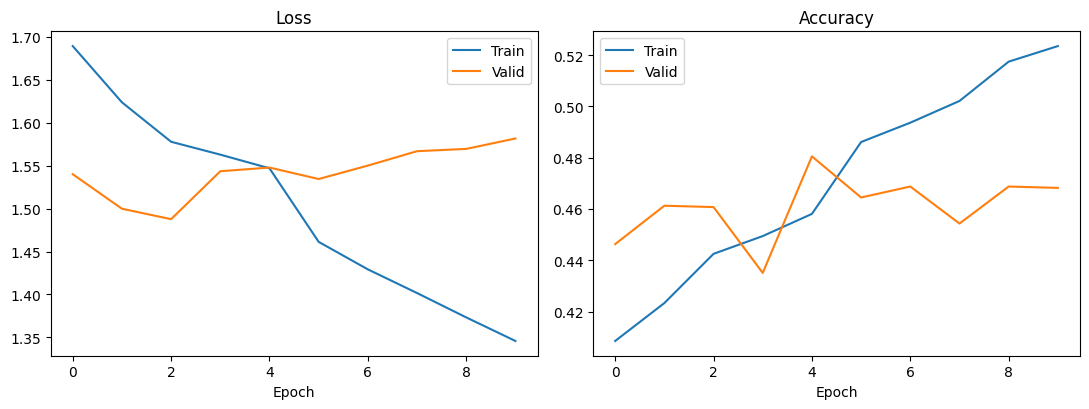

In [16]:
# =========================
# Audio-only model + SupCon(同标签为正) 训练脚本
# =========================
import math, torch, numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import os, random   # ★ 新增

# ---------- 固定随机种子 ----------
SEED = 2025827
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
# ---------------------------------
@torch.no_grad()
def compute_class_weights_from_loader(loader, num_classes: int, beta: float = 0.999, device='cpu'):
    counts = torch.zeros(num_classes, dtype=torch.float64)
    for batch in loader:
        y = batch[2] if len(batch) >= 3 else batch[1]
        y = y.view(-1)
        hist = torch.bincount(y, minlength=num_classes).to(torch.float64)
        counts[:len(hist)] += hist
    eff_num = 1.0 - (beta ** counts)
    weights = (1.0 - beta) / eff_num
    weights = weights / weights.sum() * num_classes
    return weights.to(device=device, dtype=torch.float32)

# =========================
# 训练循环（参数基本与之前一致）
# =========================
# 超参
AUDIO_DIM, HIDDEN, HEADS, NUM_CLASSES = 1024, 256, 8, 7
DROPOUT = 0.01
LR = 1e-4; WEIGHT_DECAY = 1e-2
STEP_SIZE = 5; GAMMA = 0.3
EPOCHS = 10
PATIENCE = 5
CKPT_PATH = 'acc7-audio_supcon_best.pth'

CONTRASTIVE_TARGET = 0.05       # 目标权重
CONTRASTIVE_WARMUP_EPOCHS = 5   # 线性升温
TEMP = 0.07
GRAD_CLIP = 1.0

model = AudioOnlyClassifier(audio_dim=AUDIO_DIM, hidden_dim=HIDDEN, num_heads=HEADS,
                            dropout_rate=DROPOUT, num_classes=NUM_CLASSES, proj_dim=128, temperature=TEMP).to(device)

use_cb_weight = True
if use_cb_weight:
    class_weights = compute_class_weights_from_loader(train_loader, num_classes=NUM_CLASSES, beta=0.999, device=device)
else:
    class_weights = None

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP)

best_val_acc, bad_epochs = 0.0, 0
train_losses, valid_losses, train_accs, valid_accs = [], [], [], []

for epoch in range(EPOCHS):
    model.train()
    total_loss = total_correct = total_count = 0
    # SupCon 权重线性 warmup
    progress = min(1.0, (epoch + 1) / max(1, CONTRASTIVE_WARMUP_EPOCHS))
    contrastive_weight = CONTRASTIVE_TARGET * progress

    for batch in train_loader:
        # 兼容 (text,audio,label) 或 (audio,label)
        if len(batch) >= 3:
            audio, labels = batch[1], batch[2]
        else:
            audio, labels = batch
        audio, labels = audio.to(device), labels.to(device)

        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=USE_AMP):
            logits, c_loss = model(audio, labels=labels)
            cls_loss = criterion(logits, labels)
            loss = cls_loss + contrastive_weight * c_loss

        # AMP 梯度缩放
        scaler.scale(loss).backward()
        if GRAD_CLIP is not None:
            scaler.unscale_(optimizer)
            nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
        scaler.step(optimizer)
        scaler.update()

        bs = labels.size(0)
        total_loss   += loss.item() * bs
        total_correct+= (logits.argmax(dim=1) == labels).sum().item()
        total_count  += bs

    train_losses.append(total_loss / max(1, total_count))
    train_accs.append(total_correct / max(1, total_count))
    scheduler.step()

    # ---- Valid ----
    model.eval()
    v_loss = v_correct = v_count = 0
    with torch.no_grad():
        for batch in valid_loader:
            if len(batch) >= 3:
                audio, labels = batch[1], batch[2]
            else:
                audio, labels = batch
            audio, labels = audio.to(device), labels.to(device)
            logits, c_loss = model(audio, labels=labels)
            cls_loss = criterion(logits, labels)
            loss = cls_loss + contrastive_weight * c_loss

            bs = labels.size(0)
            v_loss   += loss.item() * bs
            v_correct+= (logits.argmax(dim=1) == labels).sum().item()
            v_count  += bs

    valid_losses.append(v_loss / max(1, v_count))
    valid_accs.append(v_correct / max(1, v_count))

    print(f"Epoch {epoch+1:02d} | TrainLoss {train_losses[-1]:.4f} Acc {train_accs[-1]:.4f} | "
          f"ValLoss {valid_losses[-1]:.4f} Acc {valid_accs[-1]:.4f} | w_contrast {contrastive_weight:.3f}")

    if valid_accs[-1] > best_val_acc:
        best_val_acc, bad_epochs = valid_accs[-1], 0
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'config': {'TEMP': TEMP, 'CONTRASTIVE_TARGET': CONTRASTIVE_TARGET,
                       'CONTRASTIVE_WARMUP_EPOCHS': CONTRASTIVE_WARMUP_EPOCHS, 'USE_AMP': USE_AMP}
        }, CKPT_PATH)
        print(f"  ✅ New best model saved to {CKPT_PATH} (acc={best_val_acc:.4f})")
    else:
        bad_epochs += 1
        if bad_epochs >= PATIENCE:
            print("  ⏹️ Early stopping triggered.")
            break

print(f"[Done] Best Val Acc: {best_val_acc:.4f}")

# ---- 可选：训练/验证曲线 ----
plt.figure(figsize=(11,4.2))
plt.subplot(1,2,1); plt.plot(train_losses, label='Train'); plt.plot(valid_losses, label='Valid'); plt.title('Loss'); plt.xlabel('Epoch'); plt.legend()
plt.subplot(1,2,2); plt.plot(train_accs, label='Train'); plt.plot(valid_accs, label='Valid'); plt.title('Accuracy'); plt.xlabel('Epoch'); plt.legend()
plt.tight_layout(); plt.show()


In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from scipy.stats import pearsonr
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

# ========= 0) 工具 =========
def _strip_module_prefix(sd: dict):
    return { (k[7:] if k.startswith('module.') else k): v for k, v in sd.items() }

def load_state_flex(model, ckpt_path, device):
    ckpt = torch.load(ckpt_path, map_location=device)
    if isinstance(ckpt, dict) and ('model_state_dict' in ckpt or 'state_dict' in ckpt):
        sd = ckpt.get('model_state_dict', ckpt.get('state_dict'))
    else:
        sd = ckpt
    sd = _strip_module_prefix(sd)
    missing, unexpected = model.load_state_dict(sd, strict=False)
    if missing:
        print('[eval/load] Missing keys (<=8 shown):', list(missing)[:8])
    if unexpected:
        print('[eval/load] Unexpected keys (<=8 shown):', list(unexpected)[:8])

# ========= 1) Audio-only 模型（需与训练一致）=========
class _FFN(nn.Module):
    def __init__(self, d, drop=0.1, mult=4):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d, d*mult), nn.GELU(), nn.Dropout(drop),
            nn.Linear(d*mult, d), nn.Dropout(drop)
        )
    def forward(self, x): return self.net(x)

class _AttnPool(nn.Module):
    def __init__(self, d, drop=0.0):
        super().__init__()
        self.lin1 = nn.Linear(d, d); self.lin2 = nn.Linear(d, 1)
        self.drop = nn.Dropout(drop)
    def forward(self, x, lengths):  # x:[B,T,D]
        h = torch.tanh(self.lin1(x))
        w = self.lin2(h).squeeze(-1)
        B, T, _ = x.size()
        mask = torch.arange(T, device=x.device)[None, :] >= lengths[:, None]  # True=pad
        w = w.masked_fill(mask, -1e4)  # fp16-safe
        a = torch.softmax(w, dim=-1)
        pooled = torch.bmm(a.unsqueeze(1), x).squeeze(1)
        return self.drop(pooled), a

def sinusoidal_posenc(T: int, D: int, device):
    pe = torch.zeros(T, D, device=device)
    position = torch.arange(0, T, device=device, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, D, 2, device=device, dtype=torch.float) * (-np.log(10000.0) / D))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe

class AudioOnlyClassifier(nn.Module):
    def __init__(self, audio_dim=1024, hidden_dim=256, num_heads=8,
                 dropout_rate=0.01, num_classes=7, proj_dim=128, temperature=0.07):
        super().__init__()
        self.audio_to_hidden = nn.Linear(audio_dim, hidden_dim)
        self.self_attn = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=num_heads, dropout=dropout_rate)
        self.ln1 = nn.LayerNorm(hidden_dim)
        self.ffn = _FFN(hidden_dim, drop=dropout_rate)
        self.ln2 = nn.LayerNorm(hidden_dim)
        self.pool = _AttnPool(hidden_dim, drop=dropout_rate)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(), nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, num_classes)
        )

    @staticmethod
    def _infer_pad_mask(x):  # x:[B,T,D]  -> True=pad
        return (x.abs().sum(dim=-1) == 0)

    def forward(self, audio_features):
        a = self.audio_to_hidden(audio_features)              # [B,Ta,H]
        a_pad = self._infer_pad_mask(audio_features)          # [B,Ta]
        len_a = (~a_pad).sum(dim=1)

        B, Ta, H = a.size()
        if Ta > 0:
            a = a + sinusoidal_posenc(Ta, H, a.device).unsqueeze(0)

        aT = a.permute(1,0,2)
        saT, _ = self.self_attn(aT, aT, aT, key_padding_mask=a_pad)
        saT = saT + aT
        sa  = self.ln1(saT).permute(1,0,2)
        sa  = self.ffn(sa) + sa
        sa  = self.ln2(sa)

        pooled, _ = self.pool(sa, len_a)                      # [B,H]
        logits = self.classifier(pooled)                      # [B,C]
        return logits

# ========= 2) 准备模型与权重 =========
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
USE_AMP = torch.cuda.is_available()

model = AudioOnlyClassifier(
    audio_dim=1024, hidden_dim=256, num_heads=8,
    dropout_rate=0.01, num_classes=7, proj_dim=128, temperature=0.07
).to(device)

CKPT_PATH = 'acc7-audio_supcon_best.pth'   # 训练时保存的学生/音频模型
load_state_flex(model, CKPT_PATH, device)
model.eval()

# ========= 3) 推理收集（只用 audio）=========
true_ids, pred_ids = [], []
with torch.no_grad():
    for batch in test_loader:
        # 兼容 (text, audio, labels, ...) 或 (audio, labels)
        if len(batch) >= 3:
            audio_features, labels = batch[1], batch[2]
        else:
            audio_features, labels = batch
        audio_features = audio_features.to(device)
        labels = labels.to(device)

        with torch.cuda.amp.autocast(enabled=USE_AMP):
            logits = model(audio_features)
        pred = torch.argmax(logits, dim=1)

        pred_ids.extend(pred.cpu().numpy())
        true_ids.extend(labels.cpu().numpy())

true_ids = np.array(true_ids)
pred_ids = np.array(pred_ids)

# ========= 4) 指标 =========
acc7 = accuracy_score(true_ids, pred_ids)
precision = precision_score(true_ids, pred_ids, average='macro', zero_division=0)
recall    = recall_score(true_ids, pred_ids, average='macro', zero_division=0)
f1        = f1_score(true_ids, pred_ids, average='macro', zero_division=0)

cm = confusion_matrix(true_ids, pred_ids)
with np.errstate(divide='ignore', invalid='ignore'):
    per_class_acc = np.diag(cm) / np.sum(cm, axis=1)
    per_class_acc = np.nan_to_num(per_class_acc)
ua = per_class_acc.mean()
wa = acc7

# 还原到 [-3..3] 计算 MAE / Pearson
default_bins = np.array([-3, -2, -1, 0,  1,  2,  3], dtype=float)
if true_ids.min() >= 0 and true_ids.max() <= 6:
    bins_true = default_bins[true_ids]
    bins_pred = default_bins[pred_ids]
else:
    bins_true = true_ids.astype(float)
    bins_pred = pred_ids.astype(float)

mae = np.mean(np.abs(bins_true - bins_pred))
try:
    corr, _ = pearsonr(bins_true, bins_pred)
except Exception:
    corr = 0.0

# ========= 5) 打印 =========
print(f"[AUDIO-ONLY] Acc-7: {acc7:.4f}")
print(f"[AUDIO-ONLY] Macro Precision: {precision:.4f}")
print(f"[AUDIO-ONLY] Macro Recall:    {recall:.4f}")
print(f"[AUDIO-ONLY] Macro F1:        {f1:.4f}")
print(f"[AUDIO-ONLY] UA (macro-Acc):  {ua:.4f}")
print(f"[AUDIO-ONLY] WA (overall):    {wa:.4f}")
print(f"[AUDIO-ONLY] MAE (bins):      {mae:.4f}")
print(f"[AUDIO-ONLY] Pearson (bins):  {corr:.4f}")

target_names = [f"bin_{b:+g}" for b in [-3, -2, -1, 0, 1, 2, 3]]
print("\nClassification report (audio-only):")
if len(np.unique(true_ids)) == 7:
    print(classification_report(true_ids, pred_ids, target_names=target_names, zero_division=0))
else:
    print(classification_report(true_ids, pred_ids, zero_division=0))

# （可选）Acc-2（忽略 0 桶）：
# mask = (bins_true != 0)
# acc2 = accuracy_score(bins_true[mask] > 0, bins_pred[mask] > 0)
# print(f"[AUDIO-ONLY] Acc-2 (exclude neutral): {acc2:.4f}")


[eval/load] Unexpected keys (<=8 shown): ['proj.0.weight', 'proj.0.bias', 'proj.2.weight', 'proj.2.bias']
[AUDIO-ONLY] Acc-7: 0.4645
[AUDIO-ONLY] Macro Precision: 0.3137
[AUDIO-ONLY] Macro Recall:    0.2582
[AUDIO-ONLY] Macro F1:        0.2528
[AUDIO-ONLY] UA (macro-Acc):  0.2582
[AUDIO-ONLY] WA (overall):    0.4645
[AUDIO-ONLY] MAE (bins):      0.7199
[AUDIO-ONLY] Pearson (bins):  0.4482

Classification report (audio-only):
              precision    recall  f1-score   support

      bin_-3       0.45      0.14      0.22        70
      bin_-2       0.38      0.43      0.40       399
      bin_-1       0.00      0.00      0.00       554
      bin_+0       0.50      0.82      0.62      1926
      bin_+1       0.42      0.30      0.35      1229
      bin_+2       0.36      0.09      0.15       440
      bin_+3       0.09      0.02      0.04        41

    accuracy                           0.46      4659
   macro avg       0.31      0.26      0.25      4659
weighted avg       0.39      

text单一模态消融实验

In [19]:
# ---------- Text-only 分类器 ----------
class TextOnlyClassifier(nn.Module):
    def __init__(self, text_dim=1024, hidden_dim=256, num_heads=8,
                 dropout_rate=0.05, num_classes=7, proj_dim=128, temperature=0.07):
        super().__init__()
        self.temperature = temperature

        self.text_to_hidden = nn.Linear(text_dim, hidden_dim)
        self.self_attn = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=num_heads, dropout=dropout_rate)
        self.ln1 = nn.LayerNorm(hidden_dim)
        self.ffn = _FFN(hidden_dim, drop=dropout_rate)
        self.ln2 = nn.LayerNorm(hidden_dim)
        self.pool = _AttnPool(hidden_dim, drop=dropout_rate)

        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(), nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, num_classes)
        )
        # 对比学习投影头
        self.proj = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim), nn.GELU(), nn.Linear(hidden_dim, proj_dim)
        )

    @staticmethod
    def _infer_pad_mask(x):  # x:[B,T,D]  -> True=pad
        return (x.abs().sum(dim=-1) == 0)

    def forward(self, text_features, labels=None):
        h = self.text_to_hidden(text_features)                # [B,T,H]
        pad = self._infer_pad_mask(text_features)             # [B,T]
        lengths = (~pad).sum(dim=1)

        B, T, H = h.size()
        if T > 0:
            h = h + sinusoidal_posenc(T, H, h.device).unsqueeze(0)

        hT = h.permute(1,0,2)                                 # [T,B,H]
        saT, _ = self.self_attn(hT, hT, hT, key_padding_mask=pad)
        saT = saT + hT
        sa  = self.ln1(saT).permute(1,0,2)
        sa  = self.ffn(sa) + sa
        sa  = self.ln2(sa)

        pooled, _ = self.pool(sa, lengths)                    # [B,H]
        logits = self.classifier(pooled)                      # [B,C]

        # --- SupCon(同标签为正) ---
        supcon_loss = logits.new_zeros(())
        if labels is not None and logits.size(0) > 1:
            z = F.normalize(self.proj(pooled), dim=-1)        # [B,Dp]
            sim = torch.matmul(z, z.t()) / self.temperature   # [B,B]
            labels = labels.view(-1,1)
            pos_mask = (labels == labels.t()).float()
            eye = torch.eye(sim.size(0), device=sim.device)
            pos_mask = pos_mask * (1.0 - eye)

            log_prob = torch.log_softmax(sim, dim=1)          # [B,B]
            pos_count = pos_mask.sum(dim=1)                   # [B]
            valid = pos_count > 0
            if valid.any():
                mean_log_pos = (pos_mask[valid] * log_prob[valid]).sum(dim=1) / pos_count[valid]
                supcon_loss = -mean_log_pos.mean()

        return logits, supcon_loss


Epoch 01 | TrainLoss 1.2503 Acc 0.5141 | ValLoss 1.1686 Acc 0.5200 | w_contrast 0.010
  ✅ New best model saved to acc7-text_supcon_best.pth (acc=0.5200)
Epoch 02 | TrainLoss 1.2058 Acc 0.5259 | ValLoss 1.1584 Acc 0.5323 | w_contrast 0.020
  ✅ New best model saved to acc7-text_supcon_best.pth (acc=0.5323)
Epoch 03 | TrainLoss 1.2051 Acc 0.5374 | ValLoss 1.1858 Acc 0.5216 | w_contrast 0.030
Epoch 04 | TrainLoss 1.2027 Acc 0.5408 | ValLoss 1.1977 Acc 0.5377 | w_contrast 0.040
  ✅ New best model saved to acc7-text_supcon_best.pth (acc=0.5377)
Epoch 05 | TrainLoss 1.2059 Acc 0.5527 | ValLoss 1.2039 Acc 0.5505 | w_contrast 0.050
  ✅ New best model saved to acc7-text_supcon_best.pth (acc=0.5505)
Epoch 06 | TrainLoss 1.1499 Acc 0.5716 | ValLoss 1.2236 Acc 0.5345 | w_contrast 0.050
Epoch 07 | TrainLoss 1.1312 Acc 0.5781 | ValLoss 1.2242 Acc 0.5494 | w_contrast 0.050
Epoch 08 | TrainLoss 1.1158 Acc 0.5876 | ValLoss 1.2296 Acc 0.5446 | w_contrast 0.050
Epoch 09 | TrainLoss 1.1000 Acc 0.5964 | Val

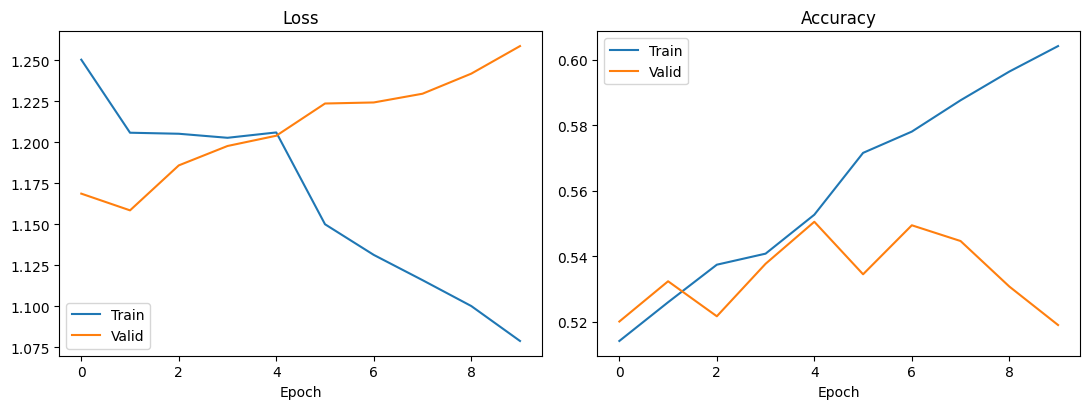

In [21]:
# =========================
# Text-only model + SupCon(同标签为正) 训练脚本
# =========================
import math, torch, numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import os, random   # ★ 新增

# ---------- 固定随机种子 ----------
SEED = 20258271
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
# ---------------------------------
@torch.no_grad()
def compute_class_weights_from_loader(loader, num_classes: int, beta: float = 0.999, device='cpu'):
    counts = torch.zeros(num_classes, dtype=torch.float64)
    for batch in loader:
        y = batch[2] if len(batch) >= 3 else batch[1]
        y = y.view(-1)
        hist = torch.bincount(y, minlength=num_classes).to(torch.float64)
        counts[:len(hist)] += hist
    eff_num = 1.0 - (beta ** counts)
    weights = (1.0 - beta) / eff_num
    weights = weights / weights.sum() * num_classes
    return weights.to(device=device, dtype=torch.float32)

# =========================
# 训练循环（参数基本与之前一致）
# =========================
# 超参
TEXT_DIM, HIDDEN, HEADS, NUM_CLASSES = 768, 256, 8, 7
DROPOUT = 0.01
LR = 1e-4; WEIGHT_DECAY = 1e-2
STEP_SIZE = 5; GAMMA = 0.3
EPOCHS = 10
PATIENCE = 5
CKPT_PATH = 'acc7-text_supcon_best.pth'

CONTRASTIVE_TARGET = 0.05       # 目标权重
CONTRASTIVE_WARMUP_EPOCHS = 5   # 线性升温
TEMP = 0.07
GRAD_CLIP = 1.0

# 用 Text-only 模型
model = TextOnlyClassifier(text_dim=TEXT_DIM, hidden_dim=HIDDEN, num_heads=HEADS,
                           dropout_rate=DROPOUT, num_classes=NUM_CLASSES,
                           proj_dim=128, temperature=TEMP).to(device)

use_cb_weight = True
if use_cb_weight:
    class_weights = compute_class_weights_from_loader(train_loader, num_classes=NUM_CLASSES, beta=0.999, device=device)
else:
    class_weights = None

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP)

best_val_acc, bad_epochs = 0.0, 0
train_losses, valid_losses, train_accs, valid_accs = [], [], [], []

for epoch in range(EPOCHS):
    model.train()
    total_loss = total_correct = total_count = 0
    # SupCon 权重线性 warmup
    progress = min(1.0, (epoch + 1) / max(1, CONTRASTIVE_WARMUP_EPOCHS))
    contrastive_weight = CONTRASTIVE_TARGET * progress

    for batch in train_loader:
        # 兼容 (text,audio,label) 或 (text,label)
        if len(batch) >= 3:
            text, labels = batch[0], batch[2]
        else:
            text, labels = batch
        text, labels = text.to(device), labels.to(device)

        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=USE_AMP):
            logits, c_loss = model(text, labels=labels)
            cls_loss = criterion(logits, labels)
            loss = cls_loss + contrastive_weight * c_loss

        # AMP 梯度缩放
        scaler.scale(loss).backward()
        if GRAD_CLIP is not None:
            scaler.unscale_(optimizer)
            nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
        scaler.step(optimizer)
        scaler.update()

        bs = labels.size(0)
        total_loss   += loss.item() * bs
        total_correct+= (logits.argmax(dim=1) == labels).sum().item()
        total_count  += bs

    train_losses.append(total_loss / max(1, total_count))
    train_accs.append(total_correct / max(1, total_count))
    scheduler.step()

    # ---- Valid ----
    model.eval()
    v_loss = v_correct = v_count = 0
    with torch.no_grad():
        for batch in valid_loader:
            if len(batch) >= 3:
                text, labels = batch[0], batch[2]
            else:
                text, labels = batch
            text, labels = text.to(device), labels.to(device)
            logits, c_loss = model(text, labels=labels)
            cls_loss = criterion(logits, labels)
            loss = cls_loss + contrastive_weight * c_loss

            bs = labels.size(0)
            v_loss   += loss.item() * bs
            v_correct+= (logits.argmax(dim=1) == labels).sum().item()
            v_count  += bs

    valid_losses.append(v_loss / max(1, v_count))
    valid_accs.append(v_correct / max(1, v_count))

    print(f"Epoch {epoch+1:02d} | TrainLoss {train_losses[-1]:.4f} Acc {train_accs[-1]:.4f} | "
          f"ValLoss {valid_losses[-1]:.4f} Acc {valid_accs[-1]:.4f} | w_contrast {contrastive_weight:.3f}")

    if valid_accs[-1] > best_val_acc:
        best_val_acc, bad_epochs = valid_accs[-1], 0
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'config': {'TEMP': TEMP, 'CONTRASTIVE_TARGET': CONTRASTIVE_TARGET,
                       'CONTRASTIVE_WARMUP_EPOCHS': CONTRASTIVE_WARMUP_EPOCHS, 'USE_AMP': USE_AMP}
        }, CKPT_PATH)
        print(f"  ✅ New best model saved to {CKPT_PATH} (acc={best_val_acc:.4f})")
    else:
        bad_epochs += 1
        if bad_epochs >= PATIENCE:
            print("  ⏹️ Early stopping triggered.")
            break

print(f"[Done] Best Val Acc: {best_val_acc:.4f}")

# ---- 可选：训练/验证曲线 ----
plt.figure(figsize=(11,4.2))
plt.subplot(1,2,1); plt.plot(train_losses, label='Train'); plt.plot(valid_losses, label='Valid'); plt.title('Loss'); plt.xlabel('Epoch'); plt.legend()
plt.subplot(1,2,2); plt.plot(train_accs, label='Train'); plt.plot(valid_accs, label='Valid'); plt.title('Accuracy'); plt.xlabel('Epoch'); plt.legend()
plt.tight_layout(); plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from scipy.stats import pearsonr
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

# ========= 0) 工具 =========
def _strip_module_prefix(sd: dict):
    return { (k[7:] if k.startswith('module.') else k): v for k, v in sd.items() }

def load_state_flex(model, ckpt_path, device):
    ckpt = torch.load(ckpt_path, map_location=device)
    if isinstance(ckpt, dict) and ('model_state_dict' in ckpt or 'state_dict' in ckpt):
        sd = ckpt.get('model_state_dict', ckpt.get('state_dict'))
    else:
        sd = ckpt
    sd = _strip_module_prefix(sd)
    missing, unexpected = model.load_state_dict(sd, strict=False)
    if missing:
        print('[eval/load] Missing keys (<=8 shown):', list(missing)[:8])
    if unexpected:
        print('[eval/load] Unexpected keys (<=8 shown):', list(unexpected)[:8])

# ========= 1) Text-only 模型 =========
class _FFN(nn.Module):#前向传播模块
    def __init__(self, d, drop=0.1, mult=4):#dropout预防过拟合
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d, d*mult), nn.GELU(), nn.Dropout(drop),
            nn.Linear(d*mult, d), nn.Dropout(drop)
        )
    def forward(self, x): return self.net(x)

class _AttnPool(nn.Module):
    def __init__(self, d, drop=0.0):
        super().__init__()
        self.lin1 = nn.Linear(d, d); self.lin2 = nn.Linear(d, 1)
        self.drop = nn.Dropout(drop)
    def forward(self, x, lengths):  # x:[B,T,D]
        h = torch.tanh(self.lin1(x))
        w = self.lin2(h).squeeze(-1)
        B, T, _ = x.size()
        mask = torch.arange(T, device=x.device)[None, :] >= lengths[:, None]  # True=pad
        w = w.masked_fill(mask, -1e4)
        a = torch.softmax(w, dim=-1)
        pooled = torch.bmm(a.unsqueeze(1), x).squeeze(1)
        return self.drop(pooled), a

def sinusoidal_posenc(T: int, D: int, device):
    pe = torch.zeros(T, D, device=device)
    position = torch.arange(0, T, device=device, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, D, 2, device=device, dtype=torch.float) * (-np.log(10000.0) / D))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe

class TextOnlyClassifier(nn.Module):
    def __init__(self, text_dim=1024, hidden_dim=256, num_heads=8,
                 dropout_rate=0.01, num_classes=7, proj_dim=128, temperature=0.07):
        super().__init__()
        self.text_to_hidden = nn.Linear(text_dim, hidden_dim)
        self.self_attn = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=num_heads, dropout=dropout_rate)
        self.ln1 = nn.LayerNorm(hidden_dim)
        self.ffn = _FFN(hidden_dim, drop=dropout_rate)
        self.ln2 = nn.LayerNorm(hidden_dim)
        self.pool = _AttnPool(hidden_dim, drop=dropout_rate)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(), nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, num_classes)
        )

    @staticmethod
    def _infer_pad_mask(x):  # x:[B,T,D]  -> True=pad
        return (x.abs().sum(dim=-1) == 0)

    def forward(self, text_features):
        t = self.text_to_hidden(text_features)                 # [B,Tt,H]
        t_pad = self._infer_pad_mask(text_features)            # [B,Tt]
        len_t = (~t_pad).sum(dim=1)

        B, Tt, H = t.size()
        if Tt > 0:
            t = t + sinusoidal_posenc(Tt, H, t.device).unsqueeze(0)

        tT = t.permute(1,0,2)
        saT, _ = self.self_attn(tT, tT, tT, key_padding_mask=t_pad)
        saT = saT + tT
        sa  = self.ln1(saT).permute(1,0,2)
        sa  = self.ffn(sa) + sa
        sa  = self.ln2(sa)

        pooled, _ = self.pool(sa, len_t)
        logits = self.classifier(pooled)
        return logits

# ========= 2) 准备模型与权重 =========
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
USE_AMP = torch.cuda.is_available()

model = TextOnlyClassifier(
    text_dim=768, hidden_dim=256, num_heads=8,
    dropout_rate=0.01, num_classes=7, proj_dim=128, temperature=0.07
).to(device)

CKPT_PATH = 'acc7-text_supcon_best.pth'   # 训练时保存的 text-only 模型
load_state_flex(model, CKPT_PATH, device)
model.eval()

# ========= 3) 推理收集（只用 text）=========
true_ids, pred_ids = [], []
with torch.no_grad():
    for batch in test_loader:
        # 兼容 (text, audio, labels, ...) 或 (text, labels)
        if len(batch) >= 3:
            text_features, labels = batch[0], batch[2]
        else:
            text_features, labels = batch
        text_features = text_features.to(device)
        labels = labels.to(device)

        with torch.cuda.amp.autocast(enabled=USE_AMP):
            logits = model(text_features)
        pred = torch.argmax(logits, dim=1)

        pred_ids.extend(pred.cpu().numpy())
        true_ids.extend(labels.cpu().numpy())

true_ids = np.array(true_ids)
pred_ids = np.array(pred_ids)

# ========= 4) 指标 =========
acc7 = accuracy_score(true_ids, pred_ids)
precision = precision_score(true_ids, pred_ids, average='macro', zero_division=0)
recall    = recall_score(true_ids, pred_ids, average='macro', zero_division=0)
f1        = f1_score(true_ids, pred_ids, average='macro', zero_division=0)

cm = confusion_matrix(true_ids, pred_ids)
with np.errstate(divide='ignore', invalid='ignore'):
    per_class_acc = np.diag(cm) / np.sum(cm, axis=1)
    per_class_acc = np.nan_to_num(per_class_acc)
ua = per_class_acc.mean()
wa = acc7

# 还原到 [-3..3] 计算 MAE / Pearson
default_bins = np.array([-3, -2, -1, 0,  1,  2,  3], dtype=float)
if true_ids.min() >= 0 and true_ids.max() <= 6:
    bins_true = default_bins[true_ids]
    bins_pred = default_bins[pred_ids]
else:
    bins_true = true_ids.astype(float)
    bins_pred = pred_ids.astype(float)

mae = np.mean(np.abs(bins_true - bins_pred))
try:
    corr, _ = pearsonr(bins_true, bins_pred)
except Exception:
    corr = 0.0

# ========= 5) 打印 =========
print(f"[TEXT-ONLY] Acc-7: {acc7:.4f}")
print(f"[TEXT-ONLY] Macro Precision: {precision:.4f}")
print(f"[TEXT-ONLY] Macro Recall:    {recall:.4f}")
print(f"[TEXT-ONLY] Macro F1:        {f1:.4f}")
print(f"[TEXT-ONLY] UA (macro-Acc):  {ua:.4f}")
print(f"[TEXT-ONLY] WA (overall):    {wa:.4f}")
print(f"[TEXT-ONLY] MAE (bins):      {mae:.4f}")
print(f"[TEXT-ONLY] Pearson (bins):  {corr:.4f}")

target_names = [f"bin_{b:+g}" for b in [-3, -2, -1, 0, 1, 2, 3]]
print("\nClassification report (text-only):")
if len(np.unique(true_ids)) == 7:
    print(classification_report(true_ids, pred_ids, target_names=target_names, zero_division=0))
else:
    print(classification_report(true_ids, pred_ids, zero_division=0))

# （可选）Acc-2（忽略 0 桶）：
# mask = (bins_true != 0)
# acc2 = accuracy_score(bins_true[mask] > 0, bins_pred[mask] > 0)
# print(f"[TEXT-ONLY] Acc-2 (exclude neutral): {acc2:.4f}")


[eval/load] Unexpected keys (<=8 shown): ['proj.0.weight', 'proj.0.bias', 'proj.2.weight', 'proj.2.bias']


[TEXT-ONLY] Acc-7: 0.5368
[TEXT-ONLY] Macro Precision: 0.4495
[TEXT-ONLY] Macro Recall:    0.4299
[TEXT-ONLY] Macro F1:        0.4248
[TEXT-ONLY] UA (macro-Acc):  0.4299
[TEXT-ONLY] WA (overall):    0.5368
[TEXT-ONLY] MAE (bins):      0.5366
[TEXT-ONLY] Pearson (bins):  0.7170

Classification report (text-only):
              precision    recall  f1-score   support

      bin_-3       0.33      0.57      0.42        70
      bin_-2       0.55      0.39      0.46       399
      bin_-1       0.38      0.44      0.41       554
      bin_+0       0.61      0.74      0.67      1926
      bin_+1       0.51      0.38      0.43      1229
      bin_+2       0.52      0.36      0.43       440
      bin_+3       0.26      0.12      0.17        41

    accuracy                           0.54      4659
   macro avg       0.45      0.43      0.42      4659
weighted avg       0.53      0.54      0.53      4659



为了做消融实验，给门控加了开关。

In [17]:
class TextAudioCrossAttentionClassifier(nn.Module):
    def __init__(self, text_dim, audio_dim, hidden_dim, num_heads,
                 dropout_rate=0.1, num_classes=7, proj_dim=128, modality_dropout_p=0.15,
                 temperature=0.07, same_utter_weight=2.0, use_gate: bool = False):  # <-- 新增 use_gate
        super().__init__()
        self.dropout = nn.Dropout(dropout_rate)
        self.text_to_hidden  = nn.Linear(text_dim,  hidden_dim)
        self.audio_to_hidden = nn.Linear(audio_dim, hidden_dim)

        self.cross_text_q_audio_kv = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=num_heads, dropout=dropout_rate)
        self.cross_audio_q_text_kv = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=num_heads, dropout=dropout_rate)

        self.ln_ta_1 = nn.LayerNorm(hidden_dim); self.ffn_ta = _FFN(hidden_dim, drop=dropout_rate); self.ln_ta_2 = nn.LayerNorm(hidden_dim)
        self.ln_at_1 = nn.LayerNorm(hidden_dim); self.ffn_at = _FFN(hidden_dim, drop=dropout_rate); self.ln_at_2 = nn.LayerNorm(hidden_dim)

        self.text_pool  = _AttnPool(hidden_dim, drop=dropout_rate)
        self.audio_pool = _AttnPool(hidden_dim, drop=dropout_rate)

        self.use_gate = use_gate
        if self.use_gate:
            self.gate = nn.Sequential(
                nn.Linear(hidden_dim*2, hidden_dim), nn.ReLU(),
                nn.Linear(hidden_dim, 1), nn.Sigmoid()
            )
        # 分类器不变（输入仍是 2*H）
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim), nn.ReLU(),
            nn.Dropout(dropout_rate), nn.Linear(hidden_dim, num_classes)
        )

        self.proj_t = nn.Sequential(nn.Linear(hidden_dim, hidden_dim), nn.GELU(), nn.Linear(hidden_dim, proj_dim))
        self.proj_a = nn.Sequential(nn.Linear(hidden_dim, hidden_dim), nn.GELU(), nn.Linear(hidden_dim, proj_dim))
        self.modality_dropout_p = modality_dropout_p
        self.temperature = temperature
        self.same_utter_weight = same_utter_weight

    @staticmethod
    def _infer_pad_mask(x):  # x:[B,T,D]
        return (x.abs().sum(dim=-1) == 0)

    def _supcon(self, z_t: torch.Tensor, z_a: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
        B = z_t.size(0); T = self.temperature
        Z = torch.cat([z_t, z_a], dim=0)          # [2B, D]
        Z = F.normalize(Z, dim=-1)
        y = labels.view(-1)
        y2 = torch.cat([y, y], dim=0)             # [2B]

        mask_pos = (y2.unsqueeze(0) == y2.unsqueeze(1)).float()  # 同标签
        eye = torch.eye(2*B, device=Z.device)
        mask_pos = mask_pos * (1.0 - eye)

        W = torch.ones_like(mask_pos)
        idx = torch.arange(B, device=Z.device)
        W[idx, idx + B] = self.same_utter_weight
        W[idx + B, idx] = self.same_utter_weight

        logits = torch.matmul(Z.float(), Z.float().t()) / T
        logits = logits - 1e9 * eye
        log_prob = logits - torch.logsumexp(logits, dim=1, keepdim=True)

        weighted_logp = W * mask_pos * log_prob
        pos_weight_sum = (W * mask_pos).sum(dim=1) + 1e-8
        loss_i = - (weighted_logp.sum(dim=1) / pos_weight_sum)
        valid = pos_weight_sum > 1e-7
        return loss_i[valid].mean() if valid.any() else logits.new_zeros(())

    def forward(self, text_features, audio_features, labels=None):
        # 1) 投影到隐藏维
        t = self.text_to_hidden(text_features)    # [B,Tt,H]
        a = self.audio_to_hidden(audio_features)  # [B,Ta,H]

        # 2) mask & 长度
        t_pad = self._infer_pad_mask(text_features); a_pad = self._infer_pad_mask(audio_features)
        len_t = (~t_pad).sum(dim=1); len_a = (~a_pad).sum(dim=1)

        # 3) 位置编码
        Bt, Tt, H = t.size(); Ba, Ta, _ = a.size()
        if Tt > 0: t = t + sinusoidal_posenc(Tt, H, t.device).unsqueeze(0)
        if Ta > 0: a = a + sinusoidal_posenc(Ta, H, a.device).unsqueeze(0)

        # 4) 双向 cross-attn（MHA 需要 [T,B,H]）
        tT = t.permute(1, 0, 2); aT = a.permute(1, 0, 2)
        taT,_ = self.cross_text_q_audio_kv(query=tT, key=aT, value=aT, key_padding_mask=a_pad)
        taT = taT + tT
        ta  = self.ln_ta_1(taT).permute(1,0,2); ta = self.ffn_ta(ta) + ta; ta = self.ln_ta_2(ta); ta = self.dropout(ta)

        atT,_ = self.cross_audio_q_text_kv(query=aT, key=tT, value=tT, key_padding_mask=t_pad)
        atT = atT + aT
        at  = self.ln_at_1(atT).permute(1,0,2); at = self.ffn_at(at) + at; at = self.ln_at_2(at); at = self.dropout(at)

        # 5) 池化
        pooled_ta,_ = self.text_pool(ta, len_t)
        pooled_at,_ = self.audio_pool(at, len_a)

        # 6) 训练时的模态 dropout（保持与原结构一致）
        if self.training and self.modality_dropout_p > 0:
            drop_t = (torch.rand(pooled_ta.size(0), 1, device=pooled_ta.device) > self.modality_dropout_p).float()
            drop_a = (torch.rand(pooled_at.size(0), 1, device=pooled_at.device) > self.modality_dropout_p).float()
            pooled_ta = pooled_ta * drop_t; pooled_at = pooled_at * drop_a

        # 7) **融合：消融门控**
        if self.use_gate:
            alpha = self.gate(torch.cat([pooled_ta, pooled_at], dim=-1))
            fused = torch.cat([alpha * pooled_ta, (1 - alpha) * pooled_at], dim=-1)
        else:
            # 直接拼接，不使用门控
            fused = torch.cat([pooled_ta, pooled_at], dim=-1)

        logits = self.classifier(fused)  # [B,C]

        # 8) 监督式对比（与原实现一致）
        if logits.size(0) > 1:
            z_t = F.normalize(self.proj_t(pooled_ta), dim=-1)
            z_a = F.normalize(self.proj_a(pooled_at), dim=-1)
            if labels is not None:
                c_loss = self._supcon(z_t, z_a, labels)
            else:
                sim = torch.matmul(z_t, z_a.t()) / 0.07
                targets = torch.arange(sim.size(0), device=sim.device)
                c_loss = 0.5 * (F.cross_entropy(sim, targets) + F.cross_entropy(sim.t(), targets))
        else:
            c_loss = logits.new_zeros(())
        return logits, c_loss


Epoch 01 | TrainLoss 1.2975 Acc 0.4993 | ValLoss 1.1574 Acc 0.5387 | w_contrast 0.010
  ✅ New best model saved to acc7-textaudio_supcon_nogate_best1.20250911pth (acc=0.5387)
Epoch 02 | TrainLoss 1.2440 Acc 0.5186 | ValLoss 1.1857 Acc 0.5420 | w_contrast 0.020
  ✅ New best model saved to acc7-textaudio_supcon_nogate_best1.20250911pth (acc=0.5420)
Epoch 03 | TrainLoss 1.2385 Acc 0.5348 | ValLoss 1.1979 Acc 0.5500 | w_contrast 0.030
  ✅ New best model saved to acc7-textaudio_supcon_nogate_best1.20250911pth (acc=0.5500)
Epoch 04 | TrainLoss 1.2377 Acc 0.5458 | ValLoss 1.2120 Acc 0.5441 | w_contrast 0.040
Epoch 05 | TrainLoss 1.2453 Acc 0.5493 | ValLoss 1.2622 Acc 0.5505 | w_contrast 0.050
  ✅ New best model saved to acc7-textaudio_supcon_nogate_best1.20250911pth (acc=0.5505)
Epoch 06 | TrainLoss 1.1927 Acc 0.5642 | ValLoss 1.2280 Acc 0.5457 | w_contrast 0.050
Epoch 07 | TrainLoss 1.1765 Acc 0.5687 | ValLoss 1.2375 Acc 0.5281 | w_contrast 0.050
Epoch 08 | TrainLoss 1.1606 Acc 0.5750 | ValLo

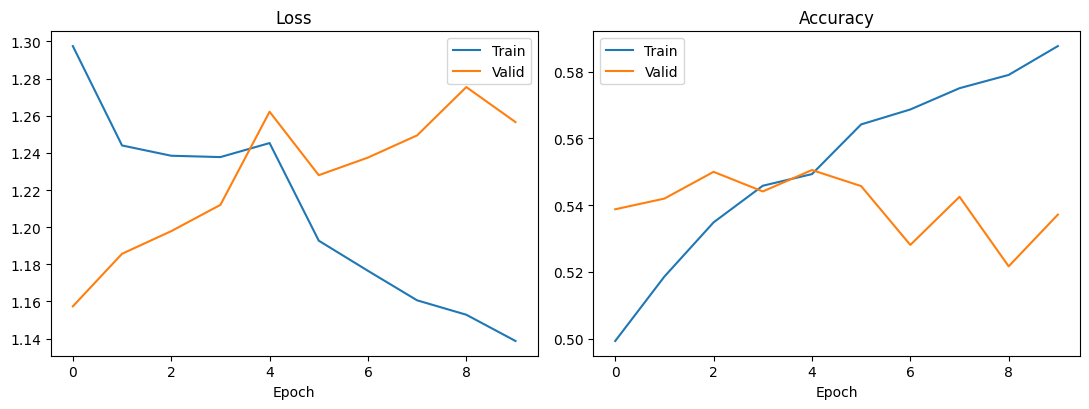

In [18]:
# =========================
# Train loop (with CB-loss, AMP, warmup for SupCon) — no-gate ablation
# =========================

import os, random, numpy as np, torch, torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

SEED = 20250911
def set_seed(seed: int):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True; torch.backends.cudnn.benchmark = False
set_seed(SEED)

def seed_worker(worker_id):
    worker_seed = (torch.initial_seed() ^ (worker_id + 1)) % 2**32
    np.random.seed(worker_seed); random.seed(worker_seed)
g_loader = torch.Generator(); g_loader.manual_seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ---- 超参
TEXT_DIM, AUDIO_DIM, HIDDEN, HEADS, NUM_CLASSES = 768, 1024, 256, 8, 7
DROPOUT = 0.01
LR = 1e-4; WEIGHT_DECAY = 1e-2
STEP_SIZE = 5; GAMMA = 0.3
EPOCHS = 10
PATIENCE = 5
CKPT_PATH = 'acc7-textaudio_supcon_nogate_best1.' + str(SEED) +'pth'  # ← 重命名以区分无门控

CONTRASTIVE_TARGET = 0.05
CONTRASTIVE_WARMUP_EPOCHS = 5
SAME_UTTER_WEIGHT = 2.0
TEMP = 0.07
GRAD_CLIP = 1.0

# ---- 模型（关闭门控）
model = TextAudioCrossAttentionClassifier(
    text_dim=TEXT_DIM, audio_dim=AUDIO_DIM, hidden_dim=HIDDEN, num_heads=HEADS,
    dropout_rate=DROPOUT, num_classes=NUM_CLASSES, proj_dim=128, modality_dropout_p=0.15,
    temperature=TEMP, same_utter_weight=SAME_UTTER_WEIGHT, use_gate=False   # ★ no-gate
).to(device)

# ---- 类权重（可关）
use_cb_weight = True
if use_cb_weight:
    class_weights = compute_class_weights_from_loader(
        train_loader, num_classes=NUM_CLASSES, beta=0.999, device=device, label_index=2
    )
else:
    class_weights = None

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

# ---- AMP
USE_AMP = torch.cuda.is_available()
scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP)

best_val_acc, bad_epochs = 0.0, 0
train_losses, valid_losses = [], []
train_accs, valid_accs = [], []

for epoch in range(EPOCHS):
    # ---- Train ----
    model.train()
    total_loss = total_correct = total_count = 0
    progress = min(1.0, (epoch + 1) / max(1, CONTRASTIVE_WARMUP_EPOCHS))
    contrastive_weight = CONTRASTIVE_TARGET * progress

    for batch in train_loader:
        if len(batch) >= 3:
            text_features, audio_features, labels = batch[:3]
        else:
            text_features, audio_features, labels = batch
        text_features = text_features.to(device); audio_features = audio_features.to(device); labels = labels.to(device)

        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=USE_AMP):
            logits, c_loss = model(text_features, audio_features, labels=labels)
            cls_loss = criterion(logits, labels)
            loss = cls_loss + contrastive_weight * c_loss

        scaler.scale(loss).backward()
        if GRAD_CLIP is not None:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
        scaler.step(optimizer)
        scaler.update()

        bs = labels.size(0)
        total_loss    += loss.item() * bs
        total_correct += (logits.argmax(dim=1) == labels).sum().item()
        total_count   += bs

    train_losses.append(total_loss / max(1, total_count))
    train_accs.append(total_correct / max(1, total_count))
    scheduler.step()

    # ---- Valid ----
    model.eval()
    v_loss = v_correct = v_count = 0
    with torch.no_grad():
        for batch in valid_loader:
            if len(batch) >= 3:
                text_features, audio_features, labels = batch[:3]
            else:
                text_features, audio_features, labels = batch
            text_features = text_features.to(device); audio_features = audio_features.to(device); labels = labels.to(device)

            with torch.cuda.amp.autocast(enabled=USE_AMP):
                logits, c_loss = model(text_features, audio_features, labels=labels)
                # 如果你想让验证不掺杂对比损失，改为：val_contrast_w = 0.0
                val_contrast_w = contrastive_weight  # ← 如需纯分类验证：改成 0.0
                cls_loss = criterion(logits, labels)
                loss = cls_loss + val_contrast_w * c_loss

            bs = labels.size(0)
            v_loss    += loss.item() * bs
            v_correct += (logits.argmax(dim=1) == labels).sum().item()
            v_count   += bs

    valid_losses.append(v_loss / max(1, v_count))
    valid_accs.append(v_correct / max(1, v_count))

    print(f"Epoch {epoch+1:02d} | TrainLoss {train_losses[-1]:.4f} Acc {train_accs[-1]:.4f} | "
          f"ValLoss {valid_losses[-1]:.4f} Acc {valid_accs[-1]:.4f} | w_contrast {contrastive_weight:.3f}")

    if valid_accs[-1] > best_val_acc:
        best_val_acc = valid_accs[-1]; bad_epochs = 0
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'random_seed': SEED,
            'config': {
                'TEMP': TEMP, 'SAME_UTTER_WEIGHT': SAME_UTTER_WEIGHT,
                'CONTRASTIVE_TARGET': CONTRASTIVE_TARGET,
                'CONTRASTIVE_WARMUP_EPOCHS': CONTRASTIVE_WARMUP_EPOCHS,
                'USE_AMP': USE_AMP, 'USE_GATE': False  # ★ 记录无门控
            }
        }, CKPT_PATH)
        print(f"  ✅ New best model saved to {CKPT_PATH} (acc={best_val_acc:.4f})")
    else:
        bad_epochs += 1
        if bad_epochs >= PATIENCE:
            print("  ⏹️ Early stopping triggered.")
            break

print(f"[Done] Best Val Acc: {best_val_acc:.4f}")

# ---- Curves
plt.figure(figsize=(11,4.2))
plt.subplot(1,2,1); plt.plot(train_losses, label='Train'); plt.plot(valid_losses, label='Valid'); plt.title('Loss'); plt.xlabel('Epoch'); plt.legend()
plt.subplot(1,2,2); plt.plot(train_accs, label='Train'); plt.plot(valid_accs, label='Valid'); plt.title('Accuracy'); plt.xlabel('Epoch'); plt.legend()
plt.tight_layout(); plt.show()


AI提示：这里有几个潜在的小问题，但为了与消融之前保持一致性，暂时不改。事后考虑稳健化。

In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from scipy.stats import pearsonr
import numpy as np
import torch

# ==== 0) 一些小工具 ====
def _strip_module_prefix(sd: dict):
    return { (k[7:] if k.startswith('module.') else k): v for k, v in sd.items() }

def load_state_flex(model, ckpt_path, device):
    ckpt = torch.load(ckpt_path, map_location=device)
    if isinstance(ckpt, dict) and ('model_state_dict' in ckpt or 'state_dict' in ckpt):
        sd = ckpt.get('model_state_dict', ckpt.get('state_dict'))
    else:
        sd = ckpt
    sd = _strip_module_prefix(sd)
    missing, unexpected = model.load_state_dict(sd, strict=False)
    if missing:
        print('[eval/load] Missing keys (show up to 8):', list(missing)[:8])
    if unexpected:
        print('[eval/load] Unexpected keys (show up to 8):', list(unexpected)[:8])

# ==== 1) 模型一致 ====
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
USE_AMP = torch.cuda.is_available()  # 推理可选 autocast

model = TextAudioCrossAttentionClassifier(
    text_dim=768,
    audio_dim=1024,
    hidden_dim=256,
    num_heads=8,
    dropout_rate=0.01,
    num_classes=7
).to(device)

best_model_path = 'acc7-textaudio_supcon_nogate_best1.' + str(SEED) +'pth' 
load_state_flex(model, best_model_path, device)
model.eval()

# ==== 2) 推理收集 ====
true_ids, pred_ids = [], []

with torch.no_grad():
    for text_features, audio_features, labels in test_loader:
        text_features = text_features.to(device)
        audio_features = audio_features.to(device)
        labels = labels.to(device)

        # AI辅助纠错，兼容新签名；评估不需要对比损失，labels 传 None 即可
        with torch.cuda.amp.autocast(enabled=USE_AMP):
            logits, _ = model(text_features, audio_features, labels=None)
        pred = torch.argmax(logits, dim=1)

        pred_ids.extend(pred.cpu().numpy())
        true_ids.extend(labels.cpu().numpy())

true_ids = np.array(true_ids)
pred_ids = np.array(pred_ids)

# ==== 3) Acc-7 / Macro-F1 等通用分类指标（基于类别 id） ====
acc7 = accuracy_score(true_ids, pred_ids)
precision = precision_score(true_ids, pred_ids, average='macro', zero_division=0)
recall    = recall_score(true_ids, pred_ids, average='macro', zero_division=0)
f1        = f1_score(true_ids, pred_ids, average='macro', zero_division=0)

cm = confusion_matrix(true_ids, pred_ids)
with np.errstate(divide='ignore', invalid='ignore'):
    per_class_acc = np.diag(cm) / np.sum(cm, axis=1)
    per_class_acc = np.nan_to_num(per_class_acc)  # 把 nan 变 0
ua = per_class_acc.mean()         # Unweighted Average
wa = acc7                         # Weighted Acc = overall Acc（样本均权）

# ==== 4) 还原到原始分段（-3..3）再算 MAE / Corr ====
default_bins = np.array([-3, -2, -1, 0, 1, 2, 3], dtype=float)
if true_ids.min() >= 0 and true_ids.max() <= 6:
    bins_true = default_bins[true_ids]
    bins_pred = default_bins[pred_ids]
else:
    bins_true = true_ids.astype(float)
    bins_pred = pred_ids.astype(float)

mae = np.mean(np.abs(bins_true - bins_pred))
try:
    corr, _ = pearsonr(bins_true, bins_pred)
except Exception:
    corr = 0.0

# ==== 5) 打印 ====
print(f"Acc-7: {acc7:.4f}")
print(f"Macro Precision: {precision:.4f}")
print(f"Macro Recall:    {recall:.4f}")
print(f"Macro F1:        {f1:.4f}")
print(f"UA (macro-Acc):  {ua:.4f}")
print(f"WA (overall):    {wa:.4f}")
print(f"MAE (bins):      {mae:.4f}")
print(f"Pearson (bins):  {corr:.4f}")

# 友好的类别名
target_names = [f"bin_{b:+g}" for b in [-3, -2, -1, 0, 1, 2, 3]]
print("\nClassification report:")
if len(np.unique(true_ids)) == 7:
    print(classification_report(true_ids, pred_ids, target_names=target_names, zero_division=0))
else:
    print(classification_report(true_ids, pred_ids, zero_division=0))


Acc-7: 0.5415
Macro Precision: 0.4457
Macro Recall:    0.4191
Macro F1:        0.4288
UA (macro-Acc):  0.4191
WA (overall):    0.5415
MAE (bins):      0.5297
Pearson (bins):  0.7217

Classification report:
              precision    recall  f1-score   support

      bin_-3       0.45      0.34      0.39        70
      bin_-2       0.51      0.56      0.53       399
      bin_-1       0.38      0.32      0.35       554
      bin_+0       0.62      0.73      0.67      1926
      bin_+1       0.51      0.41      0.45      1229
      bin_+2       0.45      0.43      0.44       440
      bin_+3       0.20      0.15      0.17        41

    accuracy                           0.54      4659
   macro avg       0.45      0.42      0.43      4659
weighted avg       0.53      0.54      0.53      4659

